# TCGA Random Forest Machine Learning

In [2]:
# Import Libraries
import gzip
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
from scipy import stats
from pprint import pprint

# Import PCA libraries
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.display import Image
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Import ML libraries

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc



print("sucess!")

sucess!


## Load in our data

In [3]:
# Load in Data + Trnasform Direction
df=pd.read_csv('log2transformed_and_normalized_gene_expression_data.csv') # load
df=df.transpose()

genes=df.loc['Unnamed: 0'].to_list() # saves all genes as list
df.columns=genes

samples=df.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df=df.drop(['Unnamed: 0']).reset_index(drop=True) # remove gene column 
df.index=samples # set index names 

df=df.astype(float) # weird nonsense step thats needed ~sometimes~
df.head() # show results

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS3P6,GSTM2,ST13P11,RANP6,NAP1L1P3,LINC00671,GAPDHP71,COG8,EIF4E2P1,ARHGAP19
TCGA.A6.5665_Tumor1,12.716704,4.833520,10.605669,9.666432,7.583105,7.746044,11.347351,11.594550,10.737055,10.027522,...,0.000000,8.526498,0.000000,0.938912,1.907370,2.481663,0.000000,9.736349,0.000000,8.861221
TCGA.AA.3662_Healthy,12.728542,4.440389,11.323393,9.904937,8.998116,7.706970,10.133867,12.214890,10.983066,10.429991,...,1.409756,7.478087,0.870630,1.409756,2.108974,0.870630,5.488914,9.867042,0.000000,8.487418
TCGA.A6.2684_Healthy,11.812955,5.701675,10.132944,9.498977,7.727813,8.735967,11.234999,11.428503,11.081855,10.148888,...,1.708694,9.612037,0.000000,0.000000,2.138477,4.077288,1.093779,10.020849,0.000000,9.067167
TCGA.A6.5659_Tumor1,14.650295,6.689371,11.628497,9.949801,9.991783,6.240809,9.251160,10.941951,12.294520,11.672900,...,0.000000,7.407009,0.000000,0.000000,4.465318,2.904814,0.000000,10.547631,9.220101,9.383200
TCGA.AA.3511_Healthy,12.432469,5.258396,12.154352,8.850606,8.023267,9.108951,11.370980,11.932527,11.113362,10.297657,...,2.661122,7.883856,0.916508,0.916508,2.185919,1.872878,3.648240,10.005464,0.000000,8.782451


### Using Gene Signature

In [4]:
df_gene_sig=df[['TREML2', 'PTPRN', 'PGLYRP1', 'NOG', 'VIP',\
    'RIMKLB', 'NKAIN4', 'FAM171B', 'ZNF417', 'GLRA2', 'HOXA7', 'FABP6', 'MUSK',\
    'HTR6', 'GRIP2', 'VEGFA', 'AKAP12', 'RHEB', 'PMEPA1','GLTP', 'METTL7A',\
    'CITED2', 'SCARA5', 'CDH3','IL6R', 'PKIB', 'GLP2R', 'EPB41L3', 'NR3C2']]

# Genes not found from gene signature (possible naming issues)
# PADI4, NCKIPSD C5orf53 TREML3 HES5 OR8D2 KLRK1 NCRNA00152 PPAP2A LINC00974

df_gene_sig.head(10)

,TREML2,PTPRN,PGLYRP1,NOG,VIP,RIMKLB,NKAIN4,FAM171B,ZNF417,GLRA2,...,GLTP,METTL7A,CITED2,SCARA5,CDH3,IL6R,PKIB,GLP2R,EPB41L3,NR3C2
TCGA.A6.5665_Tumor1,5.163865,7.045953,0.000000,2.481663,10.630085,8.925217,3.970238,7.505138,7.438055,7.065840,...,12.320419,13.399920,11.965595,11.574300,5.235852,11.012812,12.250186,8.858374,11.055709,11.847057
TCGA.AA.3662_Healthy,4.494414,5.566627,1.409756,2.765371,8.883848,7.230001,4.134978,6.968887,7.122600,7.329957,...,11.079559,10.185072,10.063010,8.463916,12.636749,9.847715,8.060350,5.980358,8.926231,9.717484
TCGA.A6.2684_Healthy,5.130507,8.512218,3.625649,4.259210,11.042827,9.282183,4.077288,8.289738,7.466139,4.495193,...,11.973354,13.375031,12.171185,12.763005,5.176484,11.718993,12.312365,8.498709,12.099533,12.006744
TCGA.A6.5659_Tumor1,1.390835,4.106267,4.992032,3.805130,6.919465,9.289066,1.390835,8.249686,11.917585,10.136038,...,10.236458,10.887394,10.581628,7.474363,10.411630,7.447798,7.262062,3.627154,8.804561,9.454988
TCGA.AA.3511_Healthy,3.017981,6.444461,1.472531,2.850558,8.858903,8.409564,5.002881,8.382962,7.238352,4.877810,...,10.939757,11.527948,10.070021,8.283735,12.064537,9.143323,8.808388,4.787968,9.854585,9.599585
TCGA.AZ.6600_Healthy,3.977576,8.669881,3.160928,4.342888,12.103200,10.055780,4.171764,8.539548,7.494323,6.288557,...,11.844244,12.943214,11.804974,12.725764,5.604791,11.635214,11.966696,8.736652,11.906556,12.022857
TCGA.A6.5667_Tumor,4.634540,5.527445,2.394234,1.829520,7.228764,6.590308,4.584222,7.082368,7.953643,6.442794,...,11.128845,9.393930,12.342774,7.161718,12.650770,8.900208,10.341715,5.059747,8.982645,8.871648
TCGA.A6.2685_Tumor,4.916248,8.422069,3.640337,3.376315,12.151396,9.643311,6.502569,8.667484,7.093277,5.550845,...,11.899099,12.661834,11.813086,10.758106,7.732441,11.215730,11.941403,9.227620,11.393996,11.491781
TCGA.A6.2684_Tumor1,3.206278,1.121457,2.511636,5.901671,4.125926,5.550007,0.000000,7.138572,6.816194,0.000000,...,11.054336,9.616860,11.261972,5.813943,11.950234,7.319355,9.069057,3.800364,7.732133,8.527413
TCGA.AA.3655_Healthy,4.446107,8.773972,4.308667,2.310769,10.452634,10.314724,4.510210,8.280703,7.767462,4.074326,...,11.363796,13.159404,11.826820,12.049773,9.089351,11.307408,9.882385,9.046760,11.920838,11.320875


### Using DESeq2

In [5]:
df_deseq=pd.read_csv('top_genes.csv') # load
df_deseq.drop(labels=['baseMean','lfcSE','stat','pvalue'],axis=1,inplace=True)
df_deseq.rename(columns={'Unnamed: 0':'genes'},inplace=True)
#num_gens=100;
#df_deseq=df_deseq[:num_gens].copy()
print(np.shape(df_deseq))
df_deseq.head()


df_SEQ=df[df_deseq['genes'].to_list()]
df_SEQ.head()

(267, 3)


,RNU4-2,SNORA73B,RNU4-1,RNY3,SNORA12,SNORA53,SNORD15B,RNU1-11P,SNORA23,SNORA22,...,LRRN3,SLC5A3,CHORDC1_2093,PLAG1,ZNF451,LYPLA1,ALG10,PABIR3,GUSBP1,SLC10A1
TCGA.A6.5665_Tumor1,0.000000,2.700992,1.502923,0.000000,0.000000,1.907370,0.938912,0.000000,0.000000,0.000000,...,6.590610,9.931882,9.158420,6.446350,10.139671,12.274157,6.830370,6.617808,8.383275,3.470914
TCGA.AA.3662_Healthy,1.409756,4.546490,0.000000,0.000000,1.409756,2.108974,2.765371,0.000000,1.409756,1.409756,...,3.557041,10.914748,9.852894,5.591628,10.295708,12.017719,6.708154,6.239579,7.581547,1.801317
TCGA.A6.2684_Healthy,1.093779,2.964573,0.000000,0.000000,1.708694,1.708694,0.000000,0.000000,0.000000,2.138477,...,7.213951,10.397222,9.747661,6.501623,9.949821,11.371584,6.622811,6.446398,6.483449,2.964573
TCGA.A6.5659_Tumor1,15.782877,12.947932,13.669877,8.729353,10.411630,11.636606,10.674774,11.299458,10.778350,11.328872,...,12.092301,13.950209,13.261148,9.557940,13.321837,12.757258,10.569358,9.471567,9.567225,7.636052
TCGA.AA.3511_Healthy,1.872878,3.303842,0.000000,0.000000,0.000000,1.872878,2.442999,0.000000,0.000000,0.916508,...,6.059141,9.745448,10.195440,7.570208,10.066443,11.846131,7.304647,6.968734,7.168865,1.872878


### Using Random Genes

In [7]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed(32)
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

## Extract tissue sample from columns (healthy or tumor)

In [8]:
# Create Target vector
target=[]
sample_names=[]

# loop through and extract tumor + healthy
for i in samples:
    
    temp=i.split('_')[1] # Split string using "_"
    #remove numbers at end (if they have it)
    if temp[-1].isnumeric():
        temp=temp[:-1]
    
    target.append(temp)# save tissues type to list (in order)

        
# Convert to Panda Series
target=pd.Series(target,name='Tissue')

In [9]:
# Convert to binary tumor=(1) + healthy=(0)
target_binary=[]
for i in target:
    if i=='Healthy':
        target_binary.append(0)
    else:
        target_binary.append(1)
        
# Convert to Panda Series
target_binary=pd.Series(target_binary)

In [10]:
# create colors labels for PCA
colors=[]
for i in target_binary:
    if i ==1:
        colors.append('orange')
    else:
        colors.append('blue')

## Vizualize data in a PCA Plots
https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

### PCA Plot Using All Genes

Text(0, 0.5, 'Component 2')

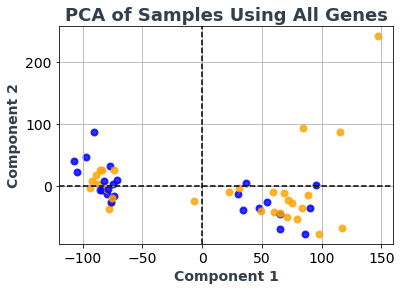

In [12]:
# Generate Colors + numbers
num_list=range(0,54)

# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df).transform(df)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA of Samples Using All Genes', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')


### PCA Plot Using Gene Signature

Text(0, 0.5, 'Component 2')

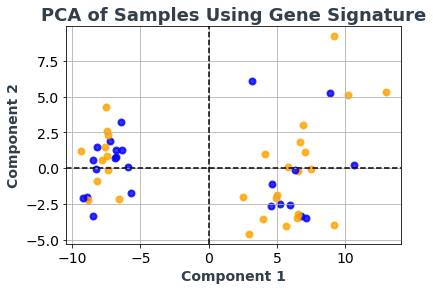

In [13]:
# Generate Colors + numbers
num_list=range(0,54)

# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df_gene_sig).transform(df_gene_sig)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA of Samples Using Gene Signature', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

### PCA Plot Using DESeq2 Signature

Text(0, 0.5, 'Component 2')

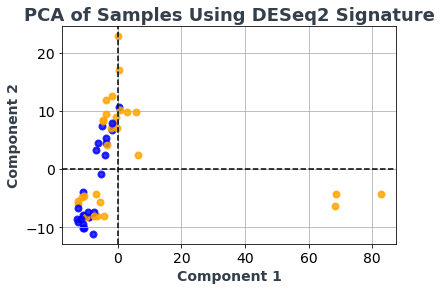

In [14]:
# Generate Colors + numbers
num_list=range(0,54)

# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df_SEQ).transform(df_SEQ)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA of Samples Using DESeq2 Signature', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

## Random Forest Model
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [95]:
# to make ROC plots
def plot_roc_curve(fpr, tpr, data_type, test_or_train, auc_k):
    plt.plot(fpr, tpr, color='orange', label=('ROC ' + data_type +' (AUC = '+str(auc_k)+")"))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve' + ' ' + test_or_train + ' ' + data_type)
    plt.legend()
    plt.show()

### Create, Train, and Test Model with Gene Signature

#### Split Into Training and Test Data

In [99]:
# independent dataset : df_gene_sig : features that determine if patient has cancer
# dependent dataset : target_bianry : diagnosis

x_train, x_test, y_train, y_test = train_test_split(df_gene_sig, target_binary, test_size=15,shuffle=True, random_state=12)
# display size of 
print('Our Training Data Set has %d patient samples'%(np.shape(x_train)[0]))
print('Our Testing Data Set has %d patient samples'%(np.shape(x_test)[0]))

Our Training Data Set has 40 patient samples
Our Testing Data Set has 15 patient samples


#### Train Data


Train Data:
[[19  0]
 [ 0 21]]
AUC: 1.0000


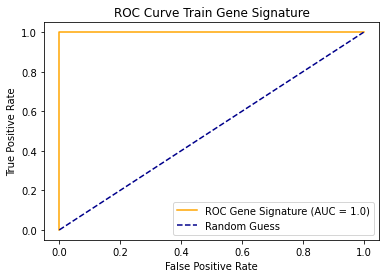

In [100]:
# X =df_gene_sig, y = target_binary,
# x_train, x_test, y_train, y_test
print('\nTrain Data:')

# Initialize random forest mode
rfc = RandomForestClassifier()

# Train model on training data
rfc.fit(x_train, y_train)

# Get the reults of the training data
results = rfc.predict(x_train)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_train, results)
print(cm)

# Generate ROC Curve
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

#predict probs for test data
probs = rfc.predict_proba(x_test)
# keep probs of positive calss only
probs = probs[:, 1]
# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'Gene Signature', 'Train', auc_k)

#### Test Data


Test Data:
[[3 2]
 [3 7]]
AUC: 0.6500


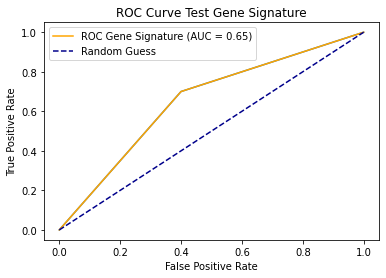

In [101]:
# Test Set - now that we've trained, we can now use test set to
print('\nTest Data:')

# run it foward - to predict using TEST
results=rfc.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)
print(cm)

# Generate ROC Curve 
fpr_rfc, tpr_rfc, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

# label for plot
plt.plot(fpr_rfc, tpr_rfc)

#predict probs for test data
probs = rfc.predict_proba(x_test)
# keep probs of positive calss only
probs = probs[:, 1]
# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'Gene Signature', 'Test', auc_k)

### Create, Train, and Test Model with DESeq2 Signature

#### Split into trainnig and testing data

In [102]:
# Re-split Data - this doesn't chnage rows but since we're using more genes we need to re-split to capture

# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(df_SEQ, target_binary, test_size=15,shuffle=True, random_state=12)
print('Our Training Data Set has %d patient samples'%(np.shape(x_train)[0]))
print('Our Testing Data Set has %d patient samples'%(np.shape(x_test)[0]))

Our Training Data Set has 40 patient samples
Our Testing Data Set has 15 patient samples


#### Train Data


Train Data:
[[19  0]
 [ 0 21]]
AUC: 1.0000


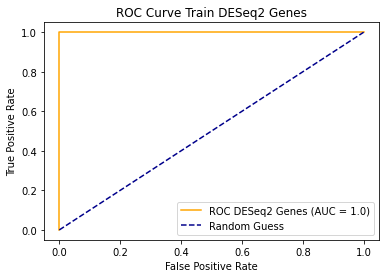

In [103]:
# X =df_gene_sig, y = target_binary,
# x_train, x_test, y_train, y_test
print('\nTrain Data:')

# Initialize random forest mode
rfc = RandomForestClassifier()

# Train model on training data
rfc.fit(x_train, y_train)

# Get the reults of the training data
results = rfc.predict(x_train)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_train, results)
print(cm)

# Generate ROC Curve
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'DESeq2 Genes', 'Train', auc_k)

#### Test Data


Test Data:
[[5 0]
 [4 6]]
AUC: 0.8000


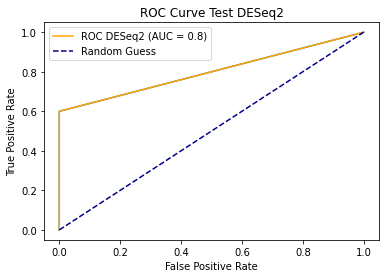

In [104]:
# Test Set - now that we've trained, we can now use test set to
print('\nTest Data:')

# run it foward - to predict using TEST
results=rfc.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)
print(cm)

# Generate ROC Curve 
fpr_rfc, tpr_rfc, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

# label for plot
plt.plot(fpr_rfc, tpr_rfc)

# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'DESeq2', 'Test', auc_k)

### Create, Train, and Test Model with Random Genes

#### Split Into Training and Test Data

In [105]:
# Re-split Data - this doesn't chnage rows but since we're using more genes we need to re-split to capture

# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)
print('Our Training Data Set has %d patient samples'%(np.shape(x_train)[0]))
print('Our Testing Data Set has %d patient samples'%(np.shape(x_test)[0]))

Our Training Data Set has 40 patient samples
Our Testing Data Set has 15 patient samples


#### Train Data


Train Data:
[[19  0]
 [ 0 21]]
AUC: 1.0000


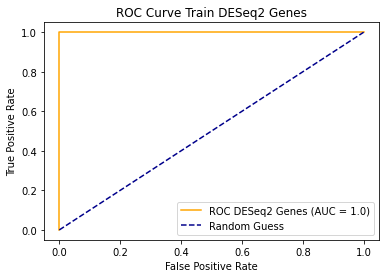

In [106]:
# X =df_gene_sig, y = target_binary,
# x_train, x_test, y_train, y_test
print('\nTrain Data:')

# Initialize random forest mode
rfc = RandomForestClassifier()

# Train model on training data
rfc.fit(x_train, y_train)

# Get the reults of the training data
results = rfc.predict(x_train)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_train, results)
print(cm)

# Generate ROC Curve
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'Random Genes', 'Train', auc_k)

#### Test Data


Test Data:
[[4 1]
 [6 4]]
AUC: 0.6000


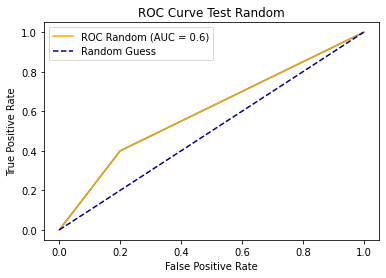

In [107]:
# Test Set - now that we've trained, we can now use test set to
print('\nTest Data:')

# run it foward - to predict using TEST
results=rfc.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)
print(cm)

# Generate ROC Curve 
fpr_rfc, tpr_rfc, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_k = auc(fpr_rfc, tpr_rfc)
print('AUC: %.4f'%(auc_k))

# label for plot
plt.plot(fpr_rfc, tpr_rfc)

# plot ROC curve usinf function
plot_roc_curve(fpr_rfc, tpr_rfc, 'Random Genes', 'Test', auc_k)

## Plot of Combined Results

## Cross Validation